$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os, sys

def add_parent_lib_path(name="Leptoquarks_Searches_2023"):
    sys.path.append(sys.path[0].split(name)[0])
    
add_parent_lib_path()

In [2]:
from Uniandes_Framework.ml_tools import tools
from Uniandes_Framework.delphes_reader import root_analysis

import pandas as pd

from ROOT import TCanvas #Permite poner los histogramas
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas
from ROOT import TLatex #Permite poner avisos en Latex en las graficas

Welcome to JupyROOT 6.22/06


In [3]:
Path_Leptoquarks_searches = os.path.dirname(os.path.dirname(os.path.realpath('XBG_Outputs_Plots_Article.ipynb')))

channels = ["hadronic_dLQ", "hadronic_sLQ", "hadronic_non-resonant", "semileptonic_dLQ", "semileptonic_sLQ", "semileptonic_non-resonant"]
signals = ['LQ_LQ', 'Tau_LQ', 'Tau_Tau'] + ['LQ_LQ_wo_RHC', 'Tau_LQ_wo_RHC', 'Tau_Tau_wo_RHC']
Masses = [
    "1000" ,
    '1250', 
    '1500', 
    '1750', 
    '2000', 
    '2250', 
    '2500'
]
bkgs = ['ttbar', 'z_jets', 'w_jets', 'stop','ww', 'wz', 'zz']

suffix_by_betard = {'wRHC': '', 'woRHC': '_wo_RHC'}
header_by_betard = {'wRHC': '#beta_{R} = -1', 'woRHC': '#beta_{R} = 0'}

In [4]:
all_histograms = {}

In [5]:
for betard in suffix_by_betard:
    all_histograms[betard] = {}

    for channel in channels:    
        all_histograms[betard][channel] = {}
        for Mass in Masses:
            path_root_file = os.path.join(f'{Path_Leptoquarks_searches}', '05_ML_Final_Distribution','Histograms', channel,f'M{Mass}', f'All_Histograms.root')   
            all_histograms[betard][channel][f'M{Mass}'] = root_analysis.Read_ROOT_File(path_root_file, expected_keys = ['Lq Lq', '#tau Lq', '#tau #tau', 'Combined', 't#bar{t}', 'stop', 'Diboson', 'V+jets'])

In [6]:
all_histograms[betard][channel][f'M{Mass}'].keys()

dict_keys(['Lq Lq', '#tau Lq', '#tau #tau', 'Combined', 't#bar{t}', 'stop', 'Diboson', 'V+jets'])

In [7]:
channel

'semileptonic_non-resonant'

In [8]:
def Overlap_Histos(Histograms, 
                   betard,
                   channel,
                   Mass, 
                   Title_Plot, 
                   Signal_to_ignore = '', 
                   alpha_bkg = 0.05, 
                   alpha_signal = 0.05, 
                   Log_Y = False, 
                   Log_X = True, 
                   Grid = False):
    
    #if Stack is False -> Histograms will be normalized by A.U
    #if Stack is True -> Histograms will be normalized by number of physical events
    
    #canvas = TCanvas(Title_Plot, " ", 0, 0, 1280, 720)
    canvas = TCanvas(Title_Plot, " ", 0, 0, 800, 600)
    
    #legend = TLegend(0.9,.4,1,.89) #Legend outside the graph
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetNColumns(4) 
    legend.SetHeader('Mass_{U}' + f'= {int(Mass)/1000} TeV' + ', g_{U} = 1.8' + ', ' + header_by_betard[betard],"C")
    legend.SetLineWidth(1)
    #legend.SetFillStyle(0) #Transparent legend window
    
    x_axis = 'XGB-Output'
    
    Histos = THStack('hist', Title_Plot)
    
    Plotting_Order = ['t#bar{t}', 'stop', 'Diboson', 'V+jets', 'Lq Lq', '#tau Lq', '#tau #tau', 'Combined']
    
    Dict_Hist = Histograms[betard][channel][f'M{Mass}']
    holes = root_analysis.review_holes_in_histograms(Dict_Hist)
    
    colors = [94,6,3,209,1,2,226,4] #https://root-forum.cern.ch/t/what-is-your-best-way-to-increment-colors/13809
    for i, key in enumerate(Plotting_Order):
        
        if key in holes: histo = root_analysis.fill_holes_in_histogram(Dict_Hist[key])
        else: histo = Dict_Hist[key]
        
        color = colors[i]
        histo.SetLineColor(color)
        
        if key in ['t#bar{t}', 'stop', 'Diboson', 'V+jets']: alpha = alpha_bkg
        else: alpha = alpha_signal
        histo.SetFillColorAlpha(color, alpha)
        histo.SetDirectory(0)  
        Histos.Add(histo)
        label = key.replace('Lq Lq', 'dLQ').replace('#tau Lq', 'sLQ').replace('#tau #tau', 'non-res')
        legend.AddEntry(histo,label)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()
        
    Histos.Draw("histnostack")
    Histos.SetTitle(f'{Title_Plot}; {x_axis}; A.U')  
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.DrawLatex(0.76,0.91,'#sqrt{s} = 13 TeV')
    #latex.DrawLatex(0.61,0.91,'#sqrt{s} = 13 TeV, L = 137 fb^{-1}')

    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(Mass)*3)          
                
    return Histos, canvas, legend

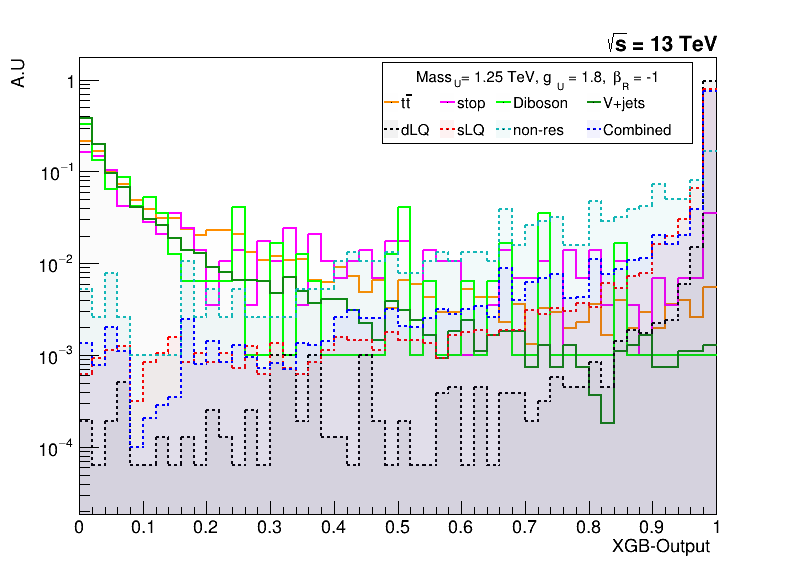

In [9]:
Histos, canvas, legend = Overlap_Histos(Histograms= all_histograms, 
                                       betard = 'wRHC',
                                       channel = "hadronic_dLQ",
                                       Mass = '1250', 
                                       Title_Plot = '', 
                                       Signal_to_ignore = '', 
                                       alpha_bkg = 0.0, 
                                       alpha_signal = 0.05, 
                                       Log_Y = True, 
                                       Log_X = False, 
                                       Grid = False)

Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_dLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: b b #tau_{h} #tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_dLQ_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_sLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: b #tau_{h} #tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_sLQ_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_non-resonant_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: #tau_{h} #tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_non-resonant_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_semileptonic_dLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deletin

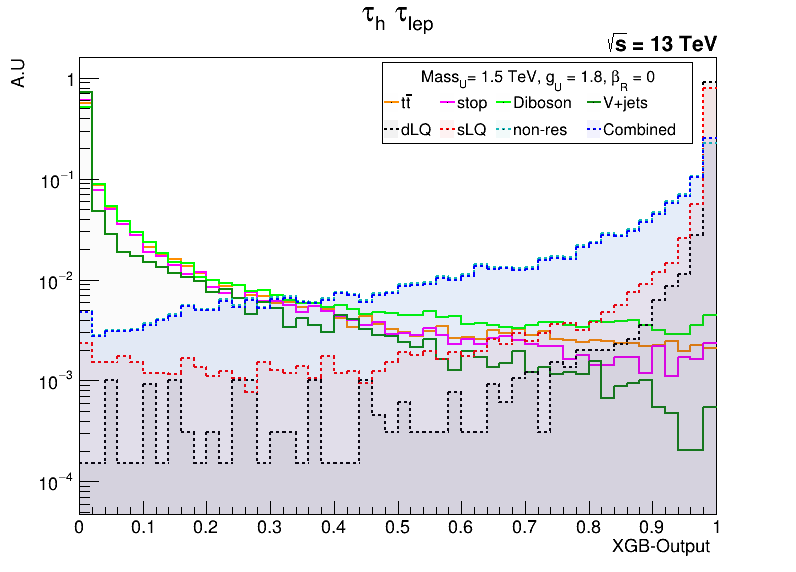

In [10]:
try: os.mkdir('Article_Histograms')
except: pass

M = '1500'

for process in channels:

    if (process == 'hadronic_non-resonant'): titulo = '#tau_{h} #tau_{h}'
    if (process == 'hadronic_sLQ'): titulo = 'b #tau_{h} #tau_{h}'
    if (process == 'hadronic_dLQ'): titulo = 'b b #tau_{h} #tau_{h}'
    if (process == 'semileptonic_non-resonant'): titulo = '#tau_{h} #tau_{lep}'
    if (process == 'semileptonic_sLQ'): titulo = 'b #tau_{h} #tau_{lep}'
    if (process == 'semileptonic_dLQ'): titulo = 'b b #tau_{h} #tau_{lep}' 

    Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                                   betard = 'wRHC',
                                   channel = process,
                                   Mass = M, 
                                   Title_Plot = titulo, 
                                   Signal_to_ignore = '', 
                                   alpha_bkg = 0.0, 
                                   alpha_signal = 0.05, 
                                   Log_Y = True, 
                                   Log_X = False, 
                                   Grid = False)

    canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_wRHC.pdf')) 
    
    Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                                   betard = 'woRHC',
                                   channel = process,
                                   Mass = M, 
                                   Title_Plot = titulo, 
                                   Signal_to_ignore = '', 
                                   alpha_bkg = 0.0, 
                                   alpha_signal = 0.05, 
                                   Log_Y = True, 
                                   Log_X = False, 
                                   Grid = False)

    canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_woRHC.pdf')) 